In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, DenseNet201
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
import urllib.request
from PIL import Image

In [1]:
# train_dir = 'E:/Image and Video Project/train'
# test_dir = 'E:/Image and Video Project/test'

# preprocessed_dir = 'E:/Image and Video Project/preprocessed'

# if not os.path.exists(preprocessed_dir):
#     os.makedirs(preprocessed_dir)

# datagen = ImageDataGenerator(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# def load_and_augment_image(image_path, datagen):
#     img = load_image(image_path)
#     img_array = np.array(img)

#     angle = np.random.randint(-40, 41)
#     img_array = rotate_image(img_array, angle)

#     tx = np.random.randint(-40, 41)
#     ty = np.random.randint(-40, 41)
#     img_array = translate_image(img_array, tx, ty)

#     shear = np.random.uniform(0.1, 0.5)
#     img_array = shear_image(img_array, shear)

#     zoom = np.random.uniform(0.8, 1.2)
#     img_array = zoom_image(img_array, zoom)

#     if np.random.rand() < 0.5:
#         img_array = np.fliplr(img_array)

#     brightness_factor = np.random.uniform(0.5, 2.0)
#     img_array = adjust_brightness(img_array, brightness_factor)

#     img = Image.fromarray(img_array)
#     return img

# def load_image(image_path):
#     return Image.open(image_path)

# def rotate_image(image, angle):
#     return cv2.warpAffine(image, cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1), (image.shape[1], image.shape[0]))

# def translate_image(image, tx, ty):
#     return cv2.warpAffine(image, np.float32([[1, 0, tx], [0, 1, ty]]), (image.shape[1], image.shape[0]))

# def shear_image(image, shear):
#     matrix = np.float32([[1, shear, 0], [0, 1, 0]])
#     return cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))

# def zoom_image(image, zoom):
#     return cv2.resize(image, None, fx=zoom, fy=zoom)

# def adjust_brightness(image, factor):
#     hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     hsv[:, :, 2] = np.clip(hsv[:, :, 2] * factor, 0, 255)
#     return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# data_dir = pathlib.Path(train_dir)
# class_names = sorted(item.name for item in data_dir.glob("*"))

# for class_name in class_names:
#     class_preprocessed_dir = os.path.join(preprocessed_dir, class_name)
#     if not os.path.exists(class_preprocessed_dir):
#         os.makedirs(class_preprocessed_dir)

#     src_train_dir = os.path.join(train_dir, class_name)
#     image_file_names = os.listdir(src_train_dir)

#     for filename in image_file_names:
#         src_image_path = os.path.join(src_train_dir, filename)
#         dst_image_path = os.path.join(class_preprocessed_dir, filename)

#         img = load_and_augment_image(src_image_path, datagen)

#         img.save(dst_image_path)

# print("Preprocessing with data augmentation complete.")


Preprocessing with data augmentation complete.


In [17]:
train_path = 'E:/Image and Video Project/preprocessed'
test_path = 'E:/Image and Video Project/test'

In [18]:
image_size = (227, 227)
batch_size = 35

In [19]:
train_augment = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.3, horizontal_flip=True)
test_augment = ImageDataGenerator(rescale=1./255)

In [20]:
final_train = train_augment.flow_from_directory(train_path, target_size=image_size, batch_size=batch_size, class_mode='categorical')

Found 4703 images belonging to 8 classes.


In [21]:
final_test = test_augment.flow_from_directory(test_path, target_size=image_size, batch_size=batch_size, class_mode='categorical')

Found 1209 images belonging to 8 classes.


In [22]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

In [23]:
# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

In [24]:
# Create a new model on top of the VGG16 base
final_arc = Sequential()
final_arc.add(base_model)
final_arc.add(Flatten())
final_arc.add(Dense(256, activation='relu'))
final_arc.add(Dense(8, activation='softmax'))

In [25]:
final_arc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten_1 (Flatten)         (None, 94080)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               24084736  
                                                                 
 dense_3 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 42408776 (161.78 MB)
Trainable params: 24086792 (91.88 MB)
Non-trainable params: 18321984 (69.89 MB)
_________________________________________________________________


In [26]:
final_arc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [28]:
vgg16_history = final_arc.fit(final_train, epochs=30, validation_data=final_test, callbacks=[early_stopping])

Epoch 1/30
135/135 [==============================] - 396s 3s/step - loss: 3.9859 - accuracy: 0.4820 - val_loss: 1.8191 - val_accuracy: 0.5178
Epoch 2/30
135/135 [==============================] - 362s 3s/step - loss: 0.9893 - accuracy: 0.6515 - val_loss: 1.5169 - val_accuracy: 0.5385
Epoch 3/30
135/135 [==============================] - 369s 3s/step - loss: 0.7395 - accuracy: 0.7104 - val_loss: 1.1400 - val_accuracy: 0.6203
Epoch 4/30
135/135 [==============================] - 371s 3s/step - loss: 0.6256 - accuracy: 0.7516 - val_loss: 0.9754 - val_accuracy: 0.6683
Epoch 5/30
135/135 [==============================] - 375s 3s/step - loss: 0.5524 - accuracy: 0.7831 - val_loss: 1.0756 - val_accuracy: 0.6443
Epoch 6/30
135/135 [==============================] - 359s 3s/step - loss: 0.5045 - accuracy: 0.8010 - val_loss: 0.9789 - val_accuracy: 0.6700
Epoch 7/30
135/135 [==============================] - 367s 3s/step - loss: 0.4561 - accuracy: 0.8227 - val_loss: 1.1139 - val_accuracy: 0.6328

In [29]:
final_arc.save('E:/Image and Video Project/densenet_8classes.h5')

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


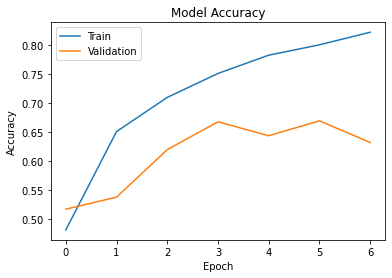

In [30]:
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()


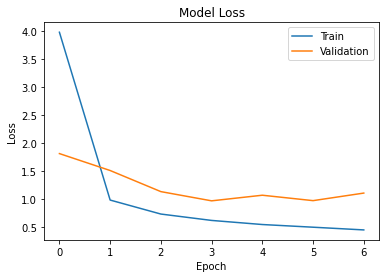

In [31]:
plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [32]:
class_labels = ['Acne and Rosacea Photos',
                'Eczema Photos',
                'Melanoma Skin Cancer Nevi and Moles',
                'Psoriasis pictures Lichen Planus and related diseases',
               'chickenpox', 'measles', 'monkeypox', 'normal']


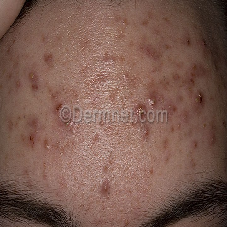

In [33]:
image_path = 'E:/Image and Video project/test/Acne and Rosacea Photos/acne-cystic-33.jpg'
img1 = load_img(image_path, target_size=image_size)
img1

In [34]:
img_array = np.expand_dims(np.array(img1) / 255.0, axis=0)

In [35]:
predictions = final_arc.predict(img_array)
predicted_class = np.argmax(predictions[0])
class_labels[predicted_class]

1/1 [==============================] - 4s 4s/step


'Acne and Rosacea Photos'

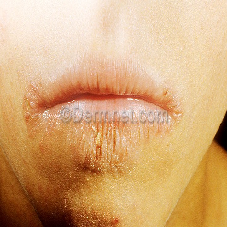

In [36]:
image_path = 'E:/Image and Video project/test/Eczema Photos/eczema-chronic-55.jpg'
img2 = load_img(image_path, target_size=image_size)
img2

In [37]:
img_array = np.expand_dims(np.array(img2) / 255.0, axis=0)

In [38]:
predictions = final_arc.predict(img_array)
predicted_class = np.argmax(predictions[0])
class_labels[predicted_class]

1/1 [==============================] - 0s 197ms/step


'normal'

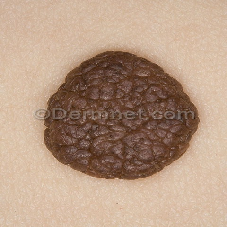

In [101]:
image_path = 'E:/Image and Video project/test/Melanoma Skin Cancer Nevi and Moles/melanocytic-nevi-24.jpg'
img3 = load_img(image_path, target_size=image_size)
img3

In [102]:
img_array = np.expand_dims(np.array(img3) / 255.0, axis=0)

In [103]:
predictions = final_arc.predict(img_array)
predicted_class = np.argmax(predictions[0])
class_labels[predicted_class]

1/1 [==============================] - 0s 204ms/step


'chickenpox'

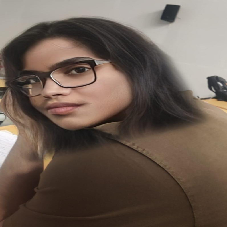

In [45]:
image_path = 'C:/Users/ASUS/OneDrive/Pictures/Saved Pictures/2.jpg'
img4 = load_img(image_path, target_size=image_size)
img4

In [46]:
img_array = np.expand_dims(np.array(img5) / 255.0, axis=0)

In [47]:
predictions = final_arc.predict(img_array)
predicted_class = np.argmax(predictions[0])
class_labels[predicted_class]

1/1 [==============================] - 0s 189ms/step


'monkeypox'

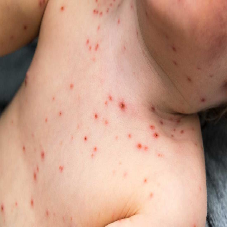

In [48]:
image_path = 'https://cdn-prod.medicalnewstoday.com/content/images/articles/322/322637/chickenpox.jpg'
urllib.request.urlretrieve(image_path, 'image.jpg')
img5 = load_img('image.jpg', target_size=image_size)
img5

In [49]:
img_array = np.expand_dims(np.array(img5) / 255.0, axis=0)

In [50]:
predictions = final_arc.predict(img_array)
predicted_class = np.argmax(predictions[0])
class_labels[predicted_class]

1/1 [==============================] - 0s 200ms/step


'Eczema Photos'